### Faz os imports e seta o diretório atual

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

import ipynbname

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

nb_fname = ipynbname.name()
nb_path = ipynbname.path()

os.chdir('{0}/..'.format(os.path.split(nb_path)[0]))

from commands.commands import commands_list

### Lê os arquivos no diretório data

In [2]:
DATASET_PATH = './data'

data_dir = pathlib.Path(DATASET_PATH)

command_audio_files = np.array(tf.io.gfile.listdir(str(data_dir)))
len(command_audio_files)

980

### Lista os comandos

In [3]:
print(commands_list)

['Sim', 'Não', 'Cima', 'Baixo', 'Esquerda', 'Direita', 'Ligado', 'Desligado', 'Parar', 'Vai', 'Zero', 'Um', 'Dois', 'Três', 'Quatro', 'Cinco', 'Seis', 'Sete', 'Oito', 'Nove', 'Cama', 'Pássaro', 'Gato', 'Cachorro', 'Feliz', 'Casa', 'Marvin', 'Sheila', 'Árvore', 'Uau', 'Trás', 'Avançar', 'Seguir', 'Aprender', 'Visual']


### Número de samples

In [4]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*.*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print("Número de samples: ", num_samples)
print('Número de samples por label: ',
      len(tf.io.gfile.glob(str(data_dir) + '/'  + str(commands_list[0]) + '*.*')))

Número de samples:  980
Número de samples por label:  28


### Decodifica o áudio

In [5]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  # Dropa um dos canais de áudio, caso o áudio seja estéreo
  return tf.squeeze(audio, axis=-1)

### Pega os labels do arquivos

In [6]:
split = tf.strings.split

def get_label(file_path):
  parts = split(input=file_path, sep=os.path.sep)[1]
  parts = split(parts, '_')[0]
  return parts

### Pega a forma de onda e o label correspondente

In [7]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label


### Separa os arquivos para o treinamento

In [8]:
train_n = int(len(filenames)*(8/10)) ### 80% dos arquivos
train_t_v = int( (len(filenames) - train_n) / 2 )

train_files = filenames[:train_n] # 80% para treino
val_files = filenames[train_n: train_n + train_t_v] # 10% para validação
test_files = filenames[-train_t_v:] # 10% para teste

print("Número de arquivos para treino: ", len(train_files))
print("Número de arquivos para validação: ", len(val_files))
print("Número de arquivos para teste: ", len(test_files))

Número de arquivos para treino:  784
Número de arquivos para validação:  98
Número de arquivos para teste:  98


### Cria um dataset a partir de train_files

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

### Exibe algumas formas de ondas

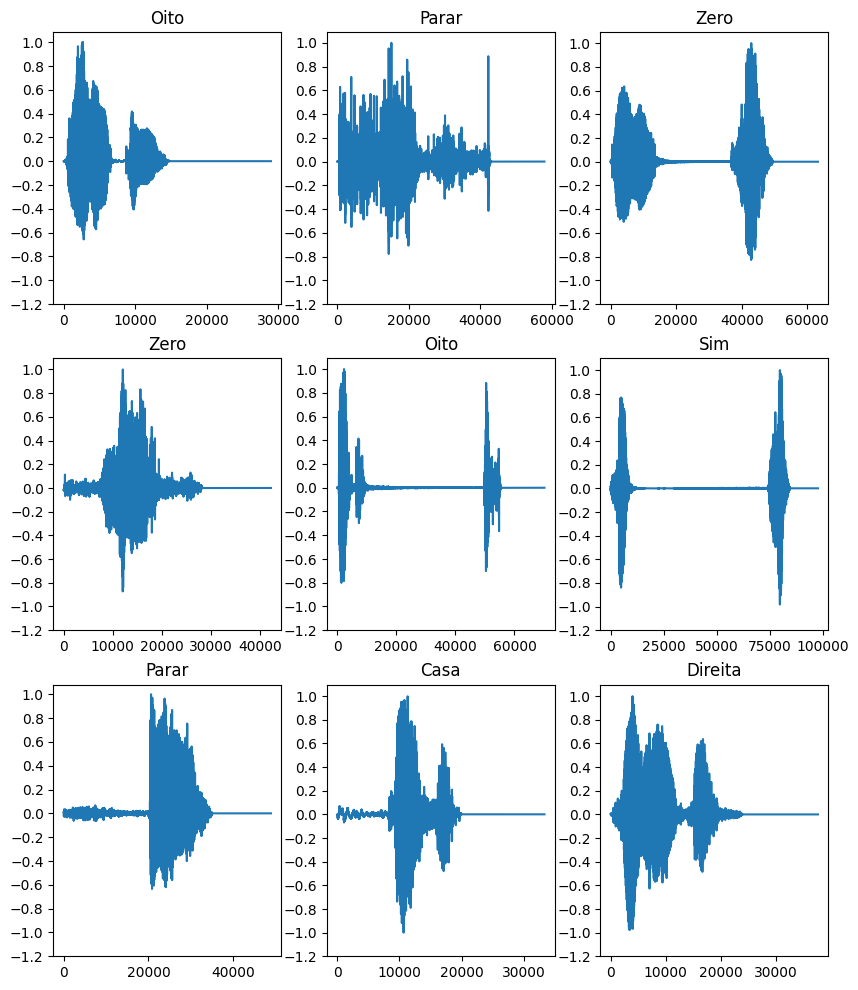

In [10]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

### Converte a forma de onda em spectograma

In [11]:
def get_spectrogram(waveform):
  # 16,000 khz.
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  waveform = tf.cast(waveform, dtype=tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  spectrogram = tf.abs(spectrogram)
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

### Fornece o áudio de um spectograma

In [12]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: Oito
Waveform shape: (28944,)
Spectrogram shape: (124, 129, 1)
Audio playback


### Função para exibir o spectograma

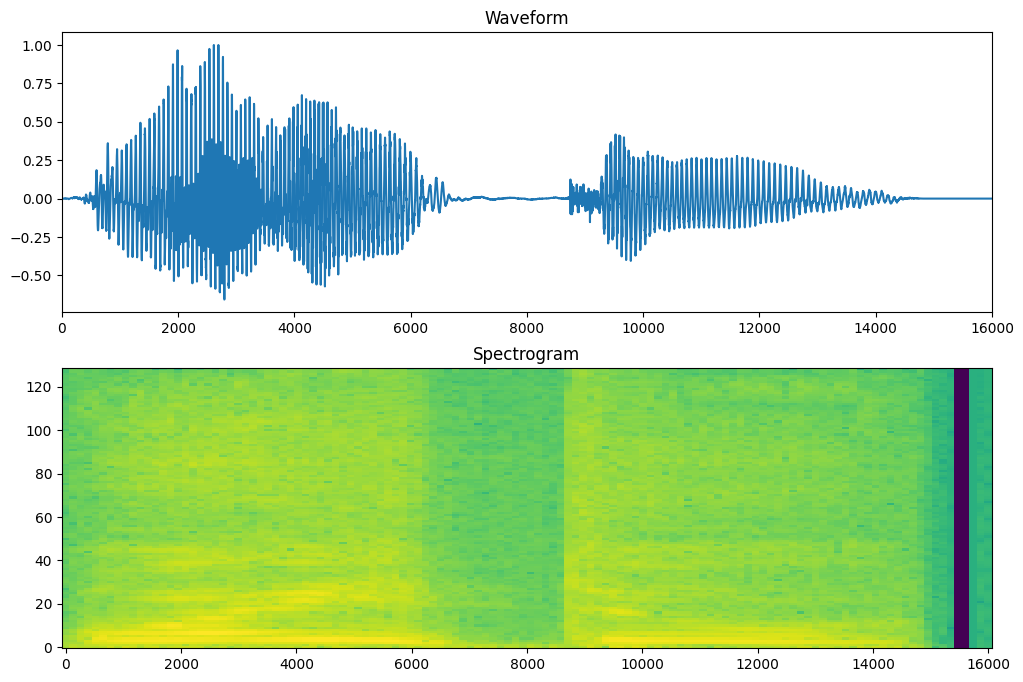

In [13]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

### Associa os spectogramas aos labels correspondentes:

In [14]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.argmax(label == commands_list)
  return spectrogram, label_id

spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

### Exibe alguns spectogramas

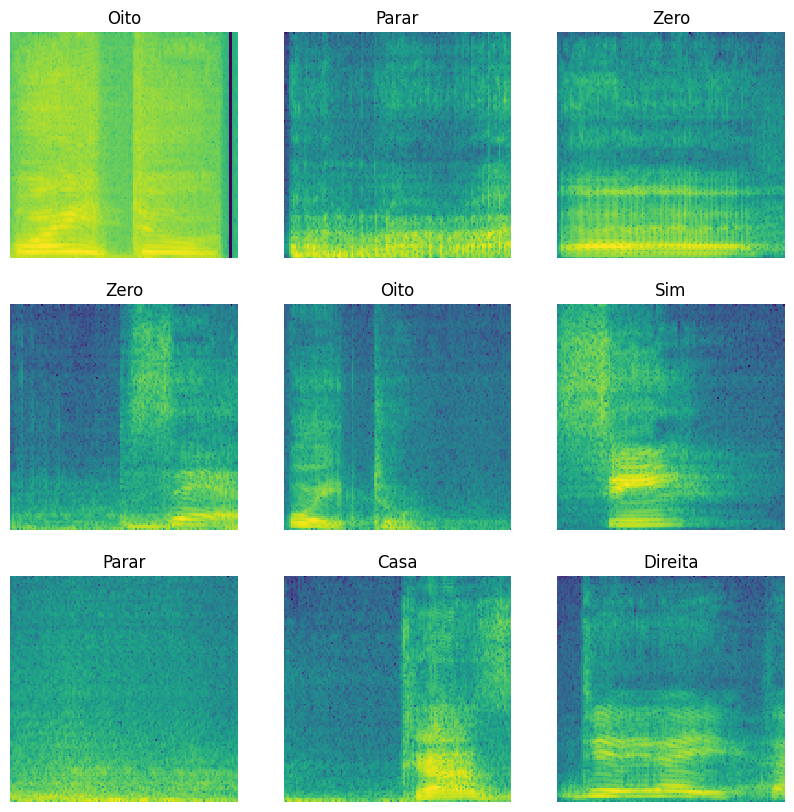

In [15]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(commands_list[label_id.numpy()])
  ax.axis('off')

plt.show()

### Pré processa os dados

In [17]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

### Agrupa os modelos e reduz a latência

In [18]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

### Cria o modelo:

In [19]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands_list)

norm_layer = layers.Normalization()
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization (Normalization)        │ (None, 32, 32, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 35)                  │           4,515 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,629,094 (6.21 MB)

 Trainable params: 1,629,091 (6.21 MB)

 Non-trainable params: 3 (16.00 B)

### Compila o modelo com a otimização e a perda

In [21]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

### Treina o modelo

In [22]:
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.0352 - loss: 3.5424 - val_accuracy: 0.1327 - val_loss: 3.4054
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.1797 - loss: 3.2632 - val_accuracy: 0.1633 - val_loss: 2.9838
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2406 - loss: 2.9212 - val_accuracy: 0.2755 - val_loss: 2.6956
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2963 - loss: 2.5734 - val_accuracy: 0.2653 - val_loss: 2.4418
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3636 - loss: 2.3338 - val_accuracy: 0.3469 - val_loss: 2.2918
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4039 - loss: 2.1441 - val_accuracy: 0.3571 - val_loss: 2.1600
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4880 - loss: 1.9122 - val_accuracy: 0.3776 - val_loss: 2.1192
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5295 - loss: 1.7108 - val_accuracy: 0.4286 - v

### Plot das curvas de perda e validação

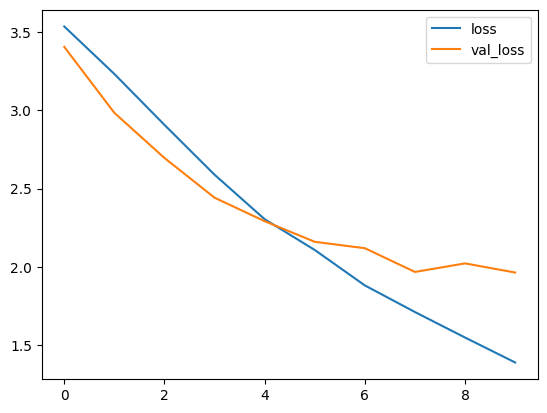

In [23]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

### Validando o desempenho do modelo

In [25]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Test set accuracy: 40%


### Exibindo a matrix de confusão

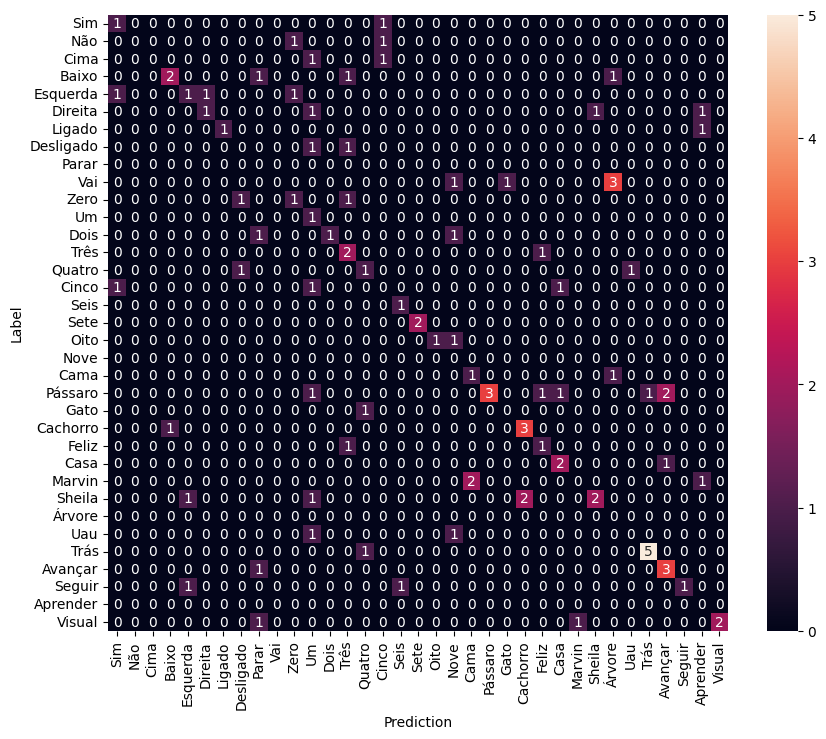

In [27]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands_list,
            yticklabels=commands_list,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

### Executando a inferência em um arquivo de áudio

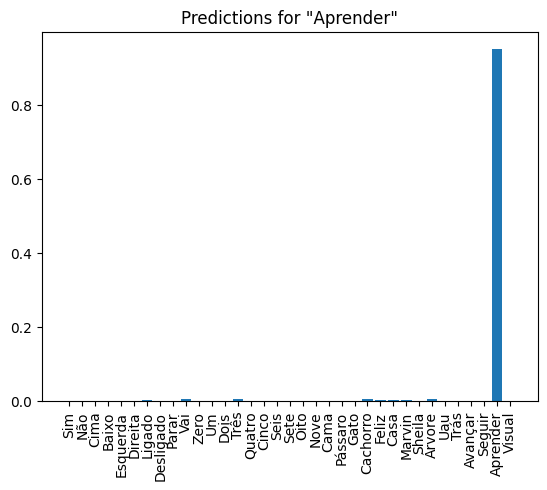

In [31]:
sample_file = data_dir/'Aprender_carokowa.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands_list, tf.nn.softmax(prediction[0]))
  plt.xticks(rotation='vertical')
  plt.title(f'Predictions for "{commands_list[label[0]]}"')
  plt.show()

### Executando outra inferência

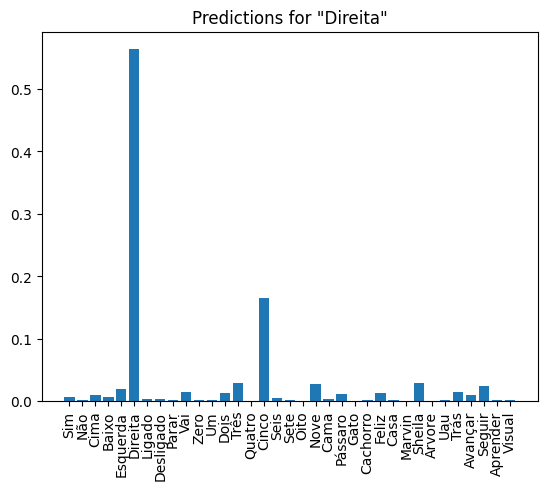

In [33]:
sample_file = data_dir/'Direita_aleatoriogps.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands_list, tf.nn.softmax(prediction[0]))
  plt.xticks(rotation='vertical')
  plt.title(f'Predictions for "{commands_list[label[0]]}"')
  plt.show()